# Gibbs textural filters comparison on BRATS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [2]:

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, ConvertToMultiChannelBasedOnBratsClassesd
from utils import show_slice_and_fourier, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Baseline pipeline

In [3]:
val_transform_baseline = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"])
    ]
)

## Load data with DecathlonDataset

In [4]:
# baseline
val_ds_baseline = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline = random_split(val_ds_baseline, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline = DataLoader(test_ds_baseline, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:59<00:00,  1.18s/it]


## Check data shape and visualize

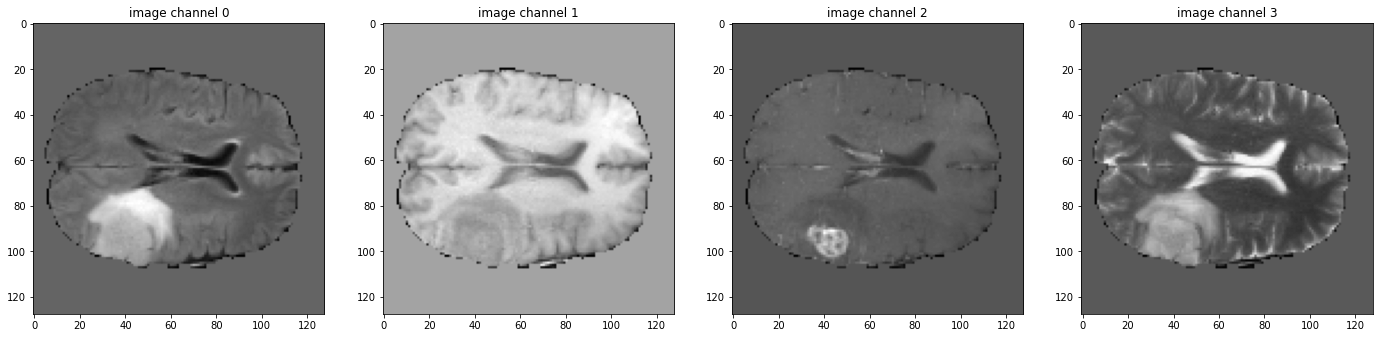

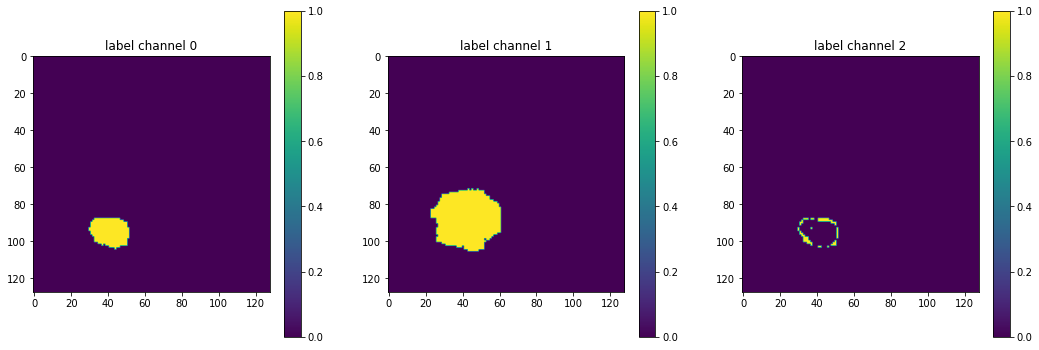

In [5]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
img = test_ds_baseline[20]['image']
label = test_ds_baseline[20]['label']



plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'image channel {i}')
    plt.imshow(img[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()


# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

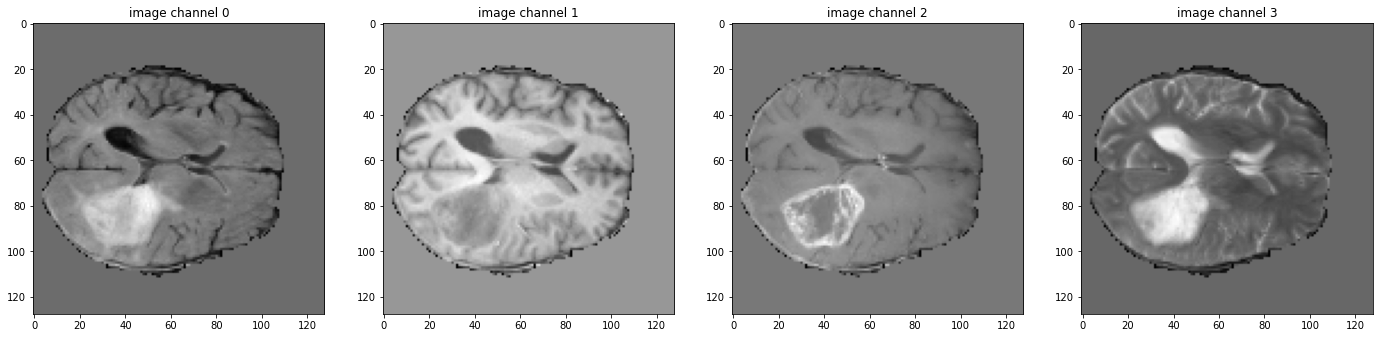

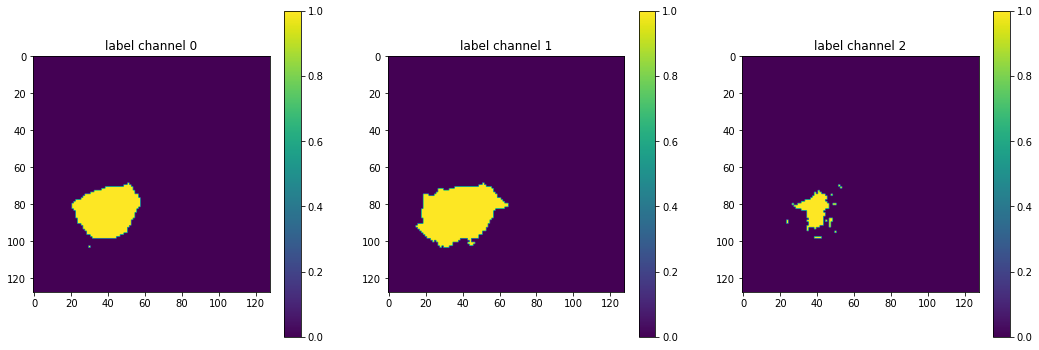

In [18]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
img = test_ds_baseline[8]['image']
label = test_ds_baseline[8]['label']



plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'image channel {i}')
    plt.imshow(img[i, :, :, 32].detach().cpu(), cmap="gray")
plt.show()


# also visualize the 3 channels label corresponding to this image
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 32].detach().cpu())
    plt.colorbar()
plt.show()

# Inference

## Check models' output with the input image and label

In [7]:
baseline = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model/best_metric_model_baseline.pth'

baseline.load_state_dict(torch.load(path))

<All keys matched successfully>

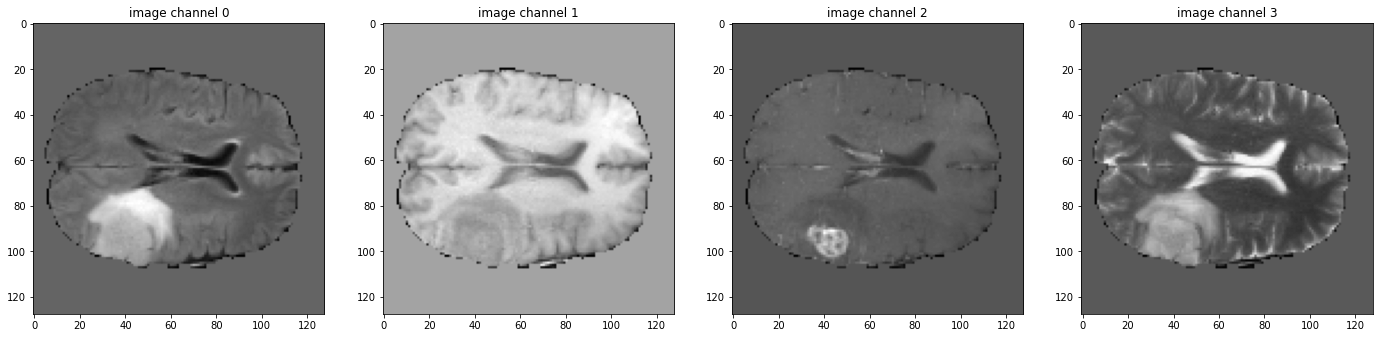

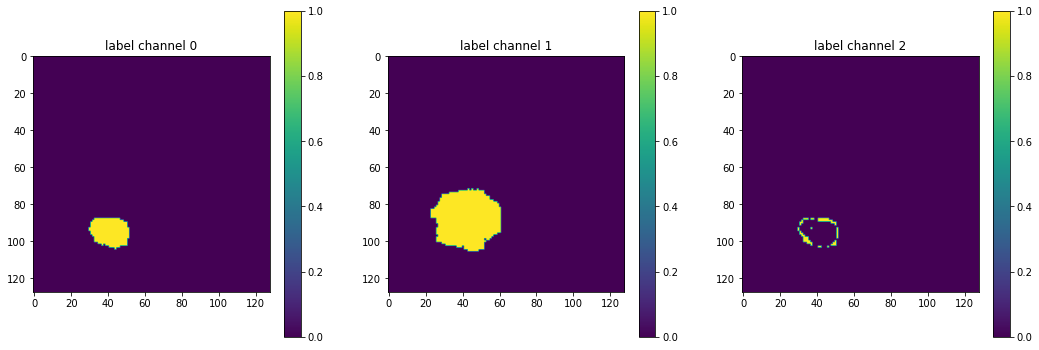

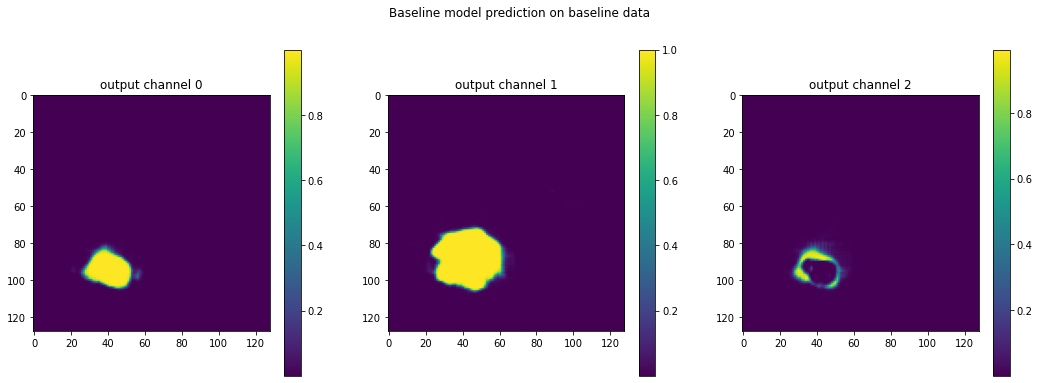

In [11]:
baseline.model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = img.unsqueeze(0).to(device)
    val_output = baseline.model(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(img[i, :, :, 32].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(label[i, :, :, 32].detach().cpu())
        plt.colorbar()
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("baseline", (18, 6))
    plt.suptitle('Baseline model prediction on baseline data')
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
        plt.colorbar()
    plt.show()

### Evaluations

In [13]:
baseline_eval = model_evaluation(path, "baseline model")
baseline_eval.add_eval('baseline_data', test_loader_baseline)

100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


In [14]:
# metric, metric_et, metric_tc, metric_wt
baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': (0.7432693392038345,
              0.5489715797205766,
              0.7797949202358723,
              0.9010415002703667)})